# Census income classification (LightGBM)

This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset.

Gradient boosting machine methods such as LightGBM are state-of-the-art for these types of predictions problems with tabular style input data of many modalities. Tree SHAP ([paper](https://arxiv.org/abs/1706.06060)) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ LightGBM code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand LightGBM model predictions. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [2]:
dtypes = [
    ("Age", "float32"), ("Workclass", "category"), ("fnlwgt", "float32"),
    ("Education", "category"), ("Education-Num", "float32"), ("Marital Status", "category"),
    ("Occupation", "category"), ("Relationship", "category"), ("Race", "category"),
    ("Sex", "category"), ("Capital Gain", "float32"), ("Capital Loss", "float32"),
    ("Hours per week", "float32"), ("Country", "category"), ("Target", "category")
]
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=[d[0] for d in dtypes],
    na_values="?",
    dtype=dict(dtypes)
)
data = raw_data.drop(["Education"], axis=1) # redundant with Education-Num
filt_dtypes = list(filter(lambda x: not (x[0] in ["Target", "Education"]), dtypes))
data["Target"] = data["Target"] == " >50K"

for k,dtype in filt_dtypes:
    if dtype == "category":
        data[k] = data[k].cat.codes

# create train and test data
train, valid = train_test_split(data, test_size=0.2)
y_train = train["Target"]
X_train = train.drop(["Target"], axis=1)
y_valid = valid["Target"]
X_valid = valid.drop(["Target"], axis=1)

## Train the model

In [3]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
model = lgb.train(params, d_train, 10000, valid_sets=[d_valid], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[926]	valid_0's binary_logloss: 0.272948


## Explain predictions

Here we take the Keras model trained above and explain why it makes different predictions for different individuals. SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.

In [4]:
X = X_valid.as_matrix()
shap_values = model.predict(X[:1000,:], pred_contrib=True)

### Create a mapping from the numeric codes to the string category names

This is not strictly nessecary, but makes the visualizations easier to understand.

In [5]:
cat_features = ["Occupation", "Relationship", "Marital Status", "Sex", "Country", "Workclass", "Race"]
val_map = {k: dict(enumerate(raw_data[k].cat.categories)) for k in cat_features}
def convert_codes(x):
    out = []
    for i,v in enumerate(filt_dtypes):
        if v[0] in val_map:
            out.append(val_map[v[0]].get(x[i], x[i]))
        else:
            out.append(x[i])
    return out

### Visualize a single prediction

Here we use a selection of 50 samples from the training dataset to represent "typical" feature values, and then use 500 evaluation samples to estimate the SHAP values for a given prediction. Note that this requires 500 * 50 evaluations of the model.

In [6]:
shap.visualize(shap_values[0,:], feature_names=X_train.columns, data=convert_codes(X[0,:]))

### Visualize many predictions

Here we repeat the above explanation process for 1,000 individuals.

In [7]:
display_values = np.vstack([convert_codes(X[i,:]) for i in range(1000)])
shap.visualize(shap_values[:1000,:], feature_names=X_train.columns, data=display_values)

[<iml.explanations.AdditiveExplanation at 0x1169d4ba8>,
 <iml.explanations.AdditiveExplanation at 0x1169d4940>,
 <iml.explanations.AdditiveExplanation at 0x1169c67b8>,
 <iml.explanations.AdditiveExplanation at 0x1169c63c8>,
 <iml.explanations.AdditiveExplanation at 0x1169c66d8>,
 <iml.explanations.AdditiveExplanation at 0x1169c6b38>,
 <iml.explanations.AdditiveExplanation at 0x1169c6be0>,
 <iml.explanations.AdditiveExplanation at 0x1169c6cf8>,
 <iml.explanations.AdditiveExplanation at 0x1169c6e10>,
 <iml.explanations.AdditiveExplanation at 0x1169c6ef0>,
 <iml.explanations.AdditiveExplanation at 0x1169c6198>,
 <iml.explanations.AdditiveExplanation at 0x1169c6128>,
 <iml.explanations.AdditiveExplanation at 0x1169d0160>,
 <iml.explanations.AdditiveExplanation at 0x1169d00b8>,
 <iml.explanations.AdditiveExplanation at 0x1169d0320>,
 <iml.explanations.AdditiveExplanation at 0x1169d0438>,
 <iml.explanations.AdditiveExplanation at 0x1169d0550>,
 <iml.explanations.AdditiveExplanation at 0x1169d0668>,
 <iml.explanations.AdditiveExplanation at 0x1169d0780>,
 <iml.explanations.AdditiveExplanation at 0x1169d0898>,
 <iml.explanations.AdditiveExplanation at 0x116ed00b8>,
 <iml.explanations.AdditiveExplanation at 0x116ed0358>,
 <iml.explanations.AdditiveExplanation at 0x116ed0470>,
 <iml.explanations.AdditiveExplanation at 0x116ed0588>,
 <iml.explanations.AdditiveExplanation at 0x116ed06a0>,
 <iml.explanations.AdditiveExplanation at 0x116ed07b8>,
 <iml.explanations.AdditiveExplanation at 0x116ed08d0>,
 <iml.explanations.AdditiveExplanation at 0x116ed09e8>,
 <iml.explanations.AdditiveExplanation at 0x116ed0b00>,
 <iml.explanations.AdditiveExplanation at 0x116ed0c18>,
 <iml.explanations.AdditiveExplanation at 0x116ed0d30>,
 <iml.explanations.AdditiveExplanation at 0x116ed0e48>,
 <iml.explanations.AdditiveExplanation at 0x116ed0f60>,
 <iml.explanations.AdditiveExplanation at 0x116ef80b8>,
 <iml.explanations.AdditiveExplanation at 0x116ef81d0>,
 <iml.explanations.AdditiveExplanation at 0x116ef82e8>,
 <iml.explanations.AdditiveExplanation at 0x116ef8400>,
 <iml.explanations.AdditiveExplanation at 0x116ef8518>,
 <iml.explanations.AdditiveExplanation at 0x116ef8630>,
 <iml.explanations.AdditiveExplanation at 0x116ef8748>,
 <iml.explanations.AdditiveExplanation at 0x116ef8860>,
 <iml.explanations.AdditiveExplanation at 0x116ef8978>,
 <iml.explanations.AdditiveExplanation at 0x116ef8a90>,
 <iml.explanations.AdditiveExplanation at 0x116ef8ba8>,
 <iml.explanations.AdditiveExplanation at 0x116ef8cc0>,
 <iml.explanations.AdditiveExplanation at 0x116ef8dd8>,
 <iml.explanations.AdditiveExplanation at 0x116ef8ef0>,
 <iml.explanations.AdditiveExplanation at 0x116f00048>,
 <iml.explanations.AdditiveExplanation at 0x116f00160>,
 <iml.explanations.AdditiveExplanation at 0x116f00278>,
 <iml.explanations.AdditiveExplanation at 0x116f00390>,
 <iml.explanations.AdditiveExplanation at 0x116f004a8>,
 <iml.explanations.AdditiveExplanation at 0x116f005c0>,
 <iml.explanations.AdditiveExplanation at 0x116f006d8>,
 <iml.explanations.AdditiveExplanation at 0x116f007f0>,
 <iml.explanations.AdditiveExplanation at 0x116f00908>,
 <iml.explanations.AdditiveExplanation at 0x116f00a20>,
 <iml.explanations.AdditiveExplanation at 0x116f00b38>,
 <iml.explanations.AdditiveExplanation at 0x116f00c50>,
 <iml.explanations.AdditiveExplanation at 0x116f00d68>,
 <iml.explanations.AdditiveExplanation at 0x116f00e80>,
 <iml.explanations.AdditiveExplanation at 0x116f00f98>,
 <iml.explanations.AdditiveExplanation at 0x116f070f0>,
 <iml.explanations.AdditiveExplanation at 0x116f07208>,
 <iml.explanations.AdditiveExplanation at 0x116f07320>,
 <iml.explanations.AdditiveExplanation at 0x116f07438>,
 <iml.explanations.AdditiveExplanation at 0x116f07550>,
 <iml.explanations.AdditiveExplanation at 0x116f07668>,
 <iml.explanations.AdditiveExplanation at 0x116f07780>,
 <iml.explanations.AdditiveExplanation at 0x116f07898>,
 <iml.explanations.AdditiveExplanation at 0x116f079b0>,
 <iml.explanations.Addit

## SHAP plots

To see the effect of a single feature across the whole dataset you can try SHAP plots, they plot a feature's value vs. the SHAP value of that feature accross many samples. SHAP plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data.  

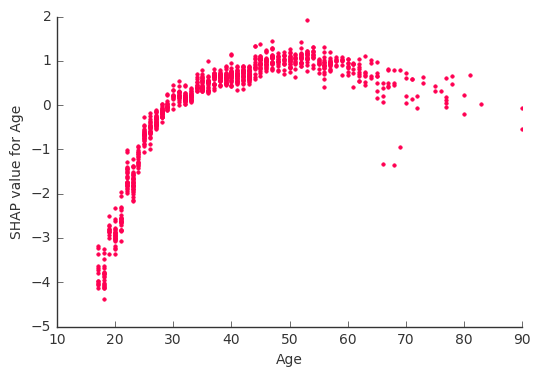

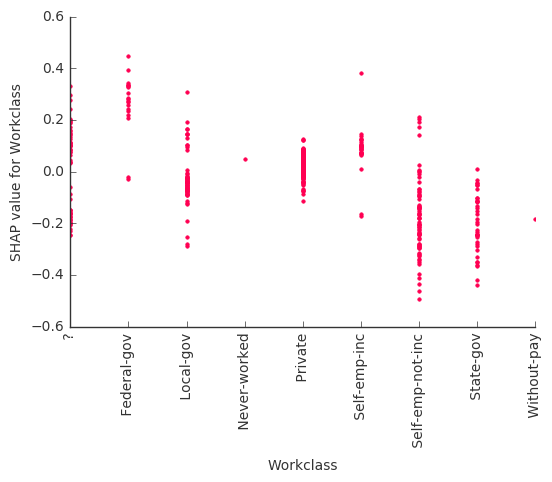

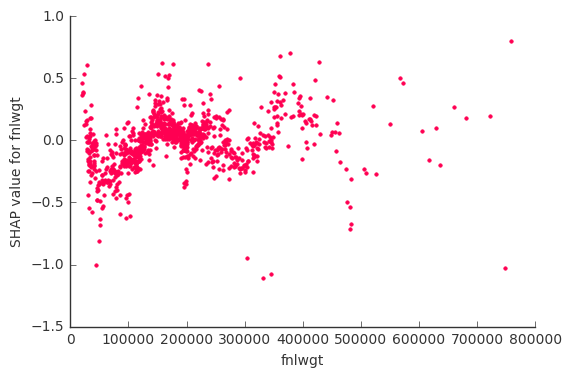

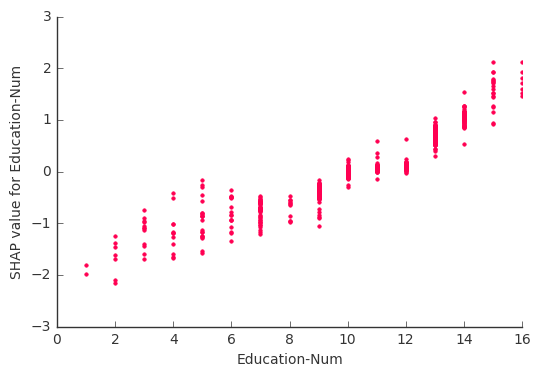

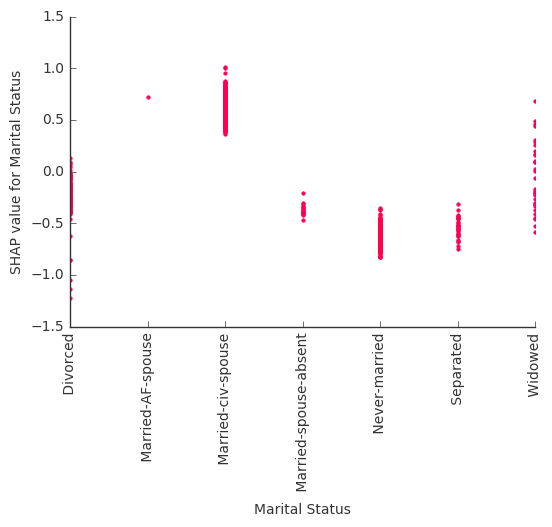

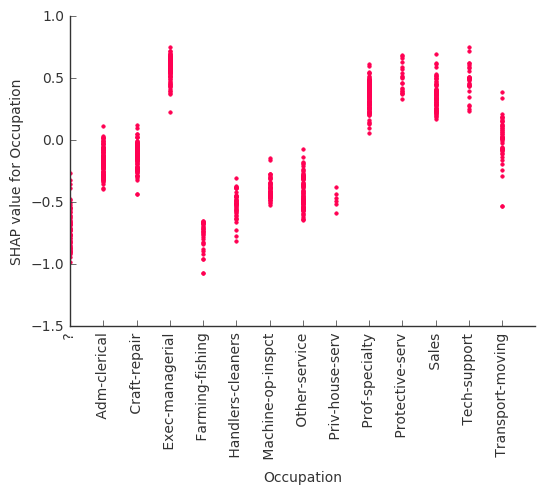

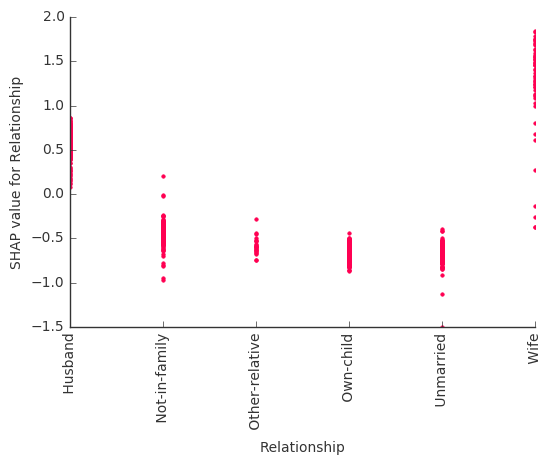

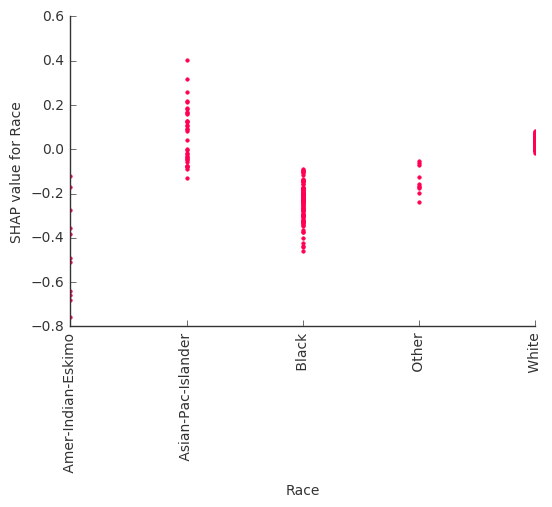

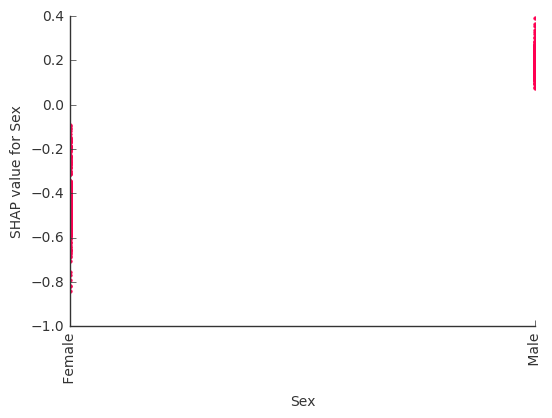

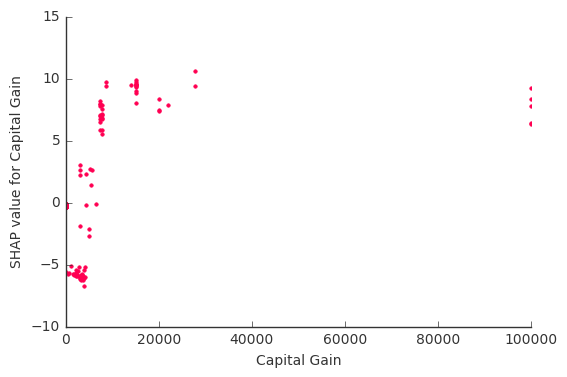

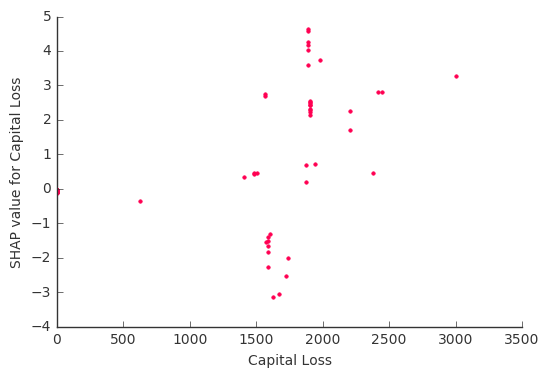

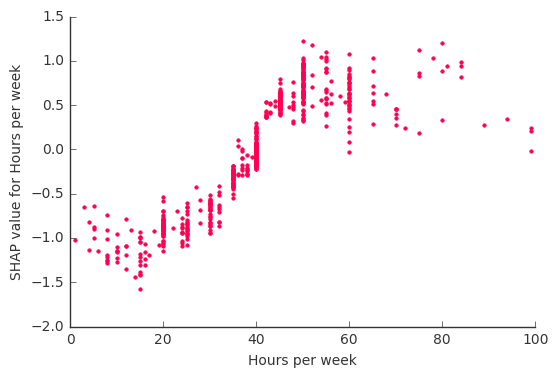

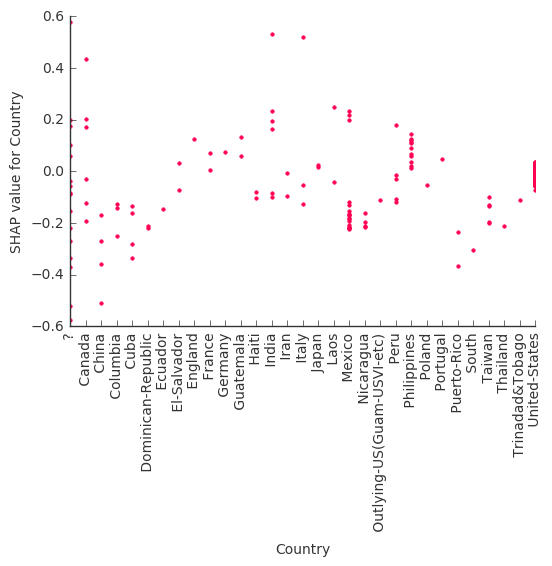

In [14]:
for name in X_train.columns:
    ind = np.where(X_train.columns == name)[0][0]
    x = X[:shap_values.shape[0],ind]
    if raw_data[name].dtype.name == "category":
        shap.plot([val_map[name][int(v)] for v in x], shap_values[:,ind], name)
    else:
        shap.plot(x, shap_values[:,ind], name)

### Train a model with only two leaves per tree and hence no interaction terms between features

Forcing the model to hace no interaction terms means the effect of a feature on the outcome does not depend on the value of any other feature. This is reflected in the SHAP plots below as no vertical spread. A vertical spread reflect that a single value of a feature can different effects on the model output depending on the context of the other features present for an individual. However for models without interaction terms a feature always has the same impact regardless of what other attributes an individual may have.

One the benefits of SHAP plots over traditional partial dependence plots is this ability to distigush between between model with and without interaction terms. In other words, SHAP plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.

In [15]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
model_ind = lgb.train(params, d_train, 20000, valid_sets=[d_valid], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's binary_logloss: 0.299878
[2000]	valid_0's binary_logloss: 0.29434
[3000]	valid_0's binary_logloss: 0.291461
[4000]	valid_0's binary_logloss: 0.28958
[5000]	valid_0's binary_logloss: 0.288167
[6000]	valid_0's binary_logloss: 0.287047
[7000]	valid_0's binary_logloss: 0.286176
[8000]	valid_0's binary_logloss: 0.285535
[9000]	valid_0's binary_logloss: 0.285008
[10000]	valid_0's binary_logloss: 0.28455
Early stopping, best iteration is:
[10265]	valid_0's binary_logloss: 0.284438


In [16]:
shap_values_ind = model_ind.predict(X[:1000,:], pred_contrib=True)

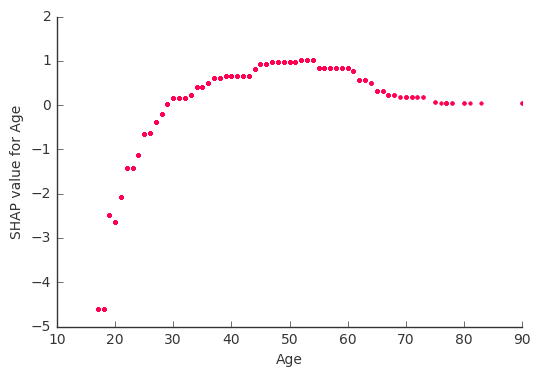

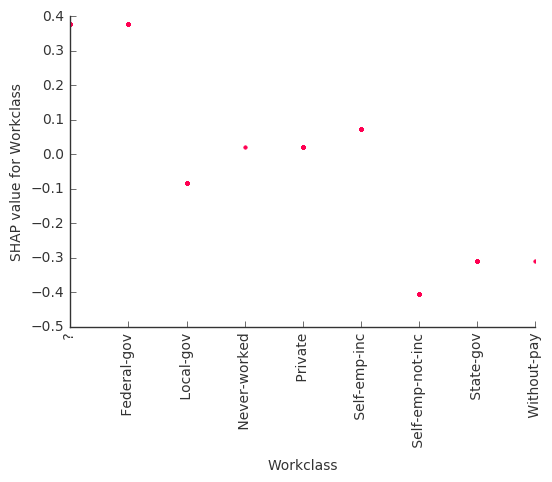

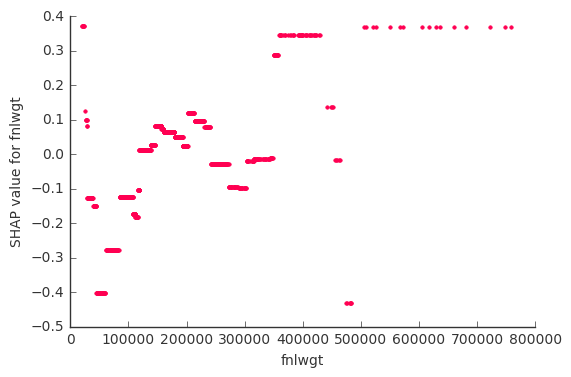

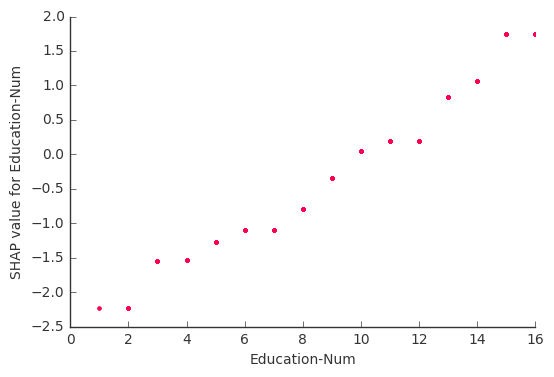

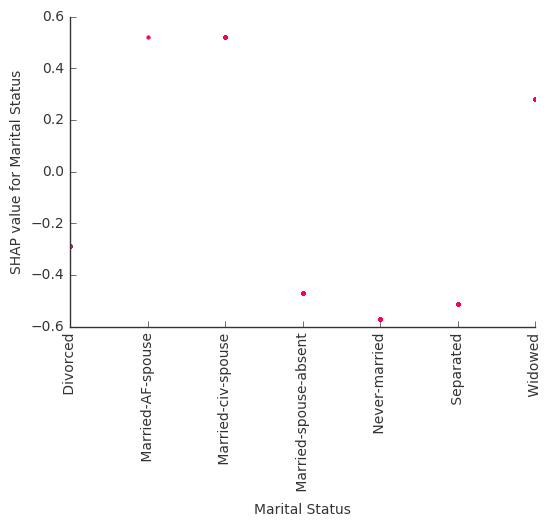

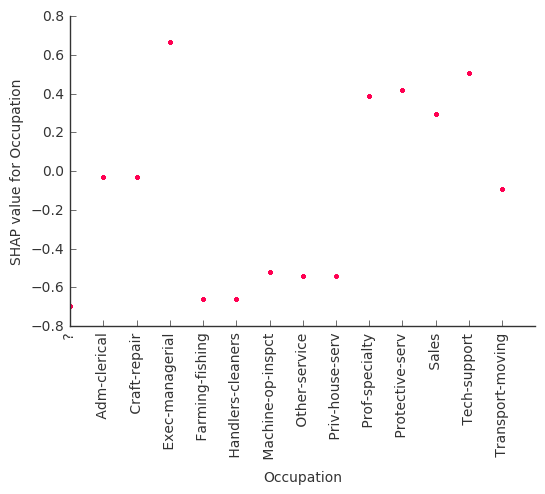

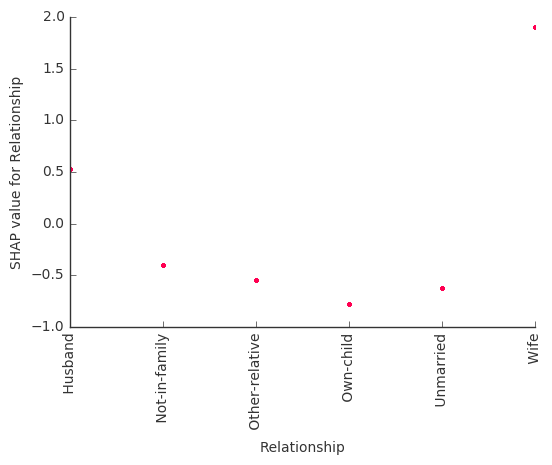

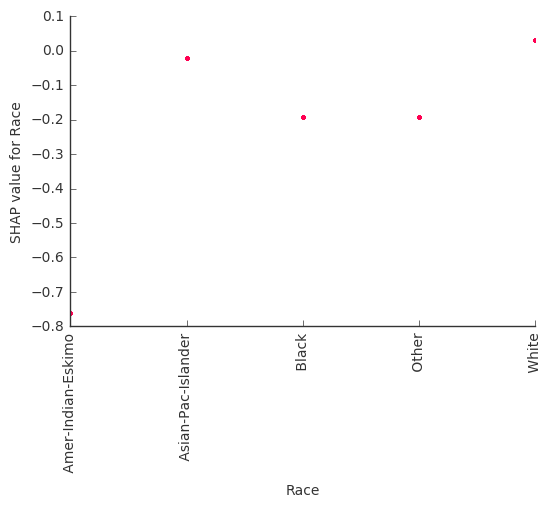

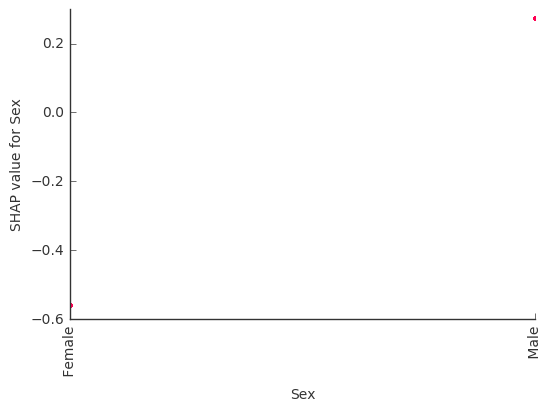

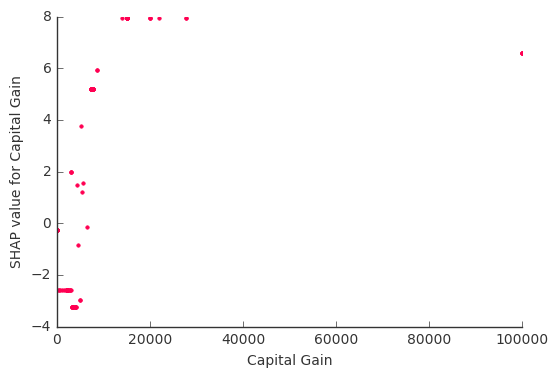

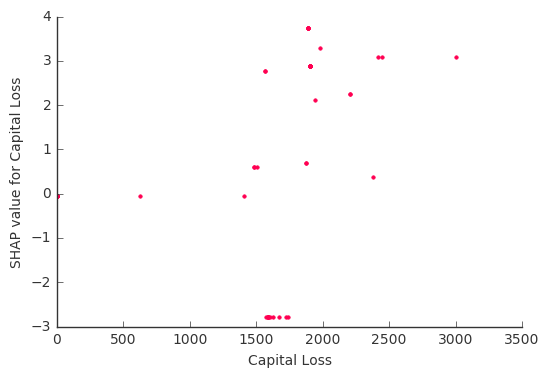

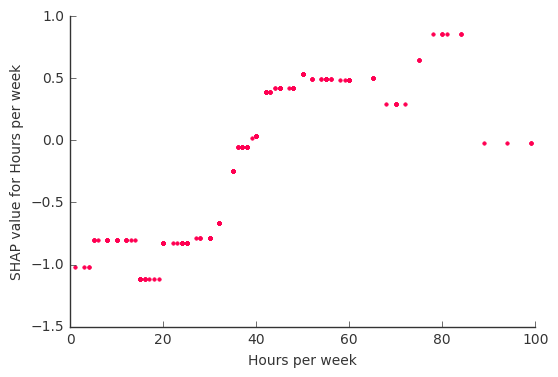

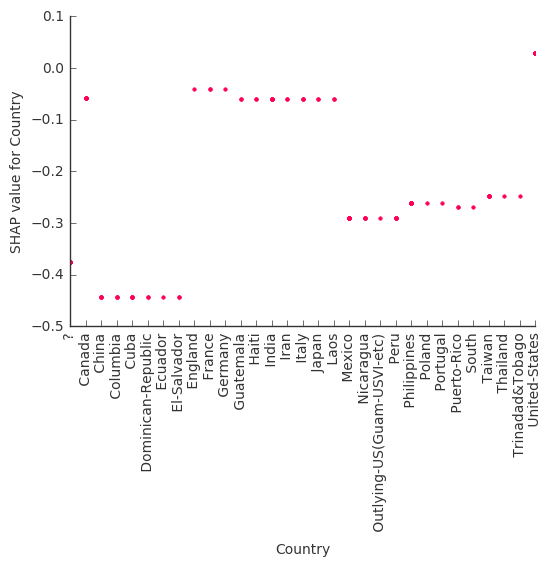

In [17]:
for name in X_train.columns:
    ind = np.where(X_train.columns == name)[0][0]
    x = X[:shap_values_ind.shape[0],ind]
    if raw_data[name].dtype.name == "category":
        shap.plot([val_map[name][int(v)] for v in x], shap_values_ind[:,ind], name)
    else:
        shap.plot(x, shap_values_ind[:,ind], name)

## Alternative visualization of SHAP values with seaborn

You can also use seaborn to plot a biclustering on the explainations to see structure in the entire model/dataset. 

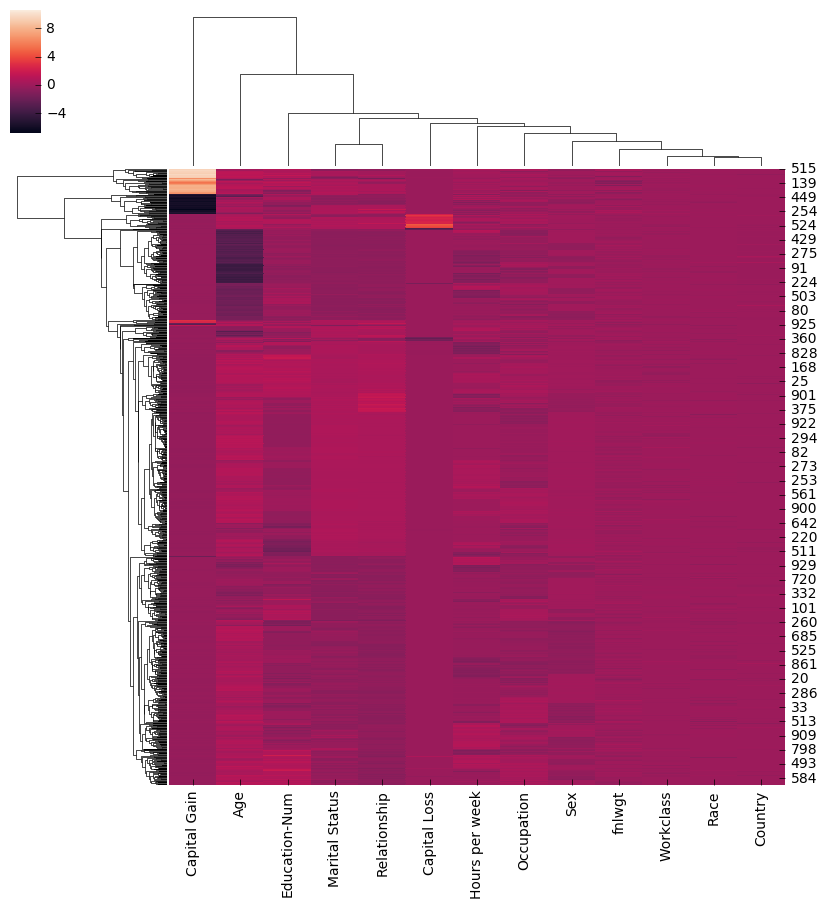

In [18]:
import seaborn
df = pd.DataFrame(data=shap_values[:,:-1],columns=X_train.columns)
seaborn.clustermap(df)